<a id = 'Content'><a/>
### Contents:
- [1.0 Imports and Functions](#1.0)
- [2.0 Models](#2.0)
    - [2.1 Random Forest Regular](#2.1)
    - [2.2 Gradient Boost Regular](#2.2)
    - [2.3 PCA model setup](#2.3)
    - [2.4 Gradient Boost w/poly features+PCA](#2.4)
    - [2.5 Log Reg w/poly features+smote+PCA](#2.5)
    - [2.6 Random Forest w/smotetomek+PCA](#2.6)
    - [2.7 Log Reg w/smote](#2.7)
    - [2.8 Gradient Boost w/smote](#2.8)
    - [2.9 Gradient Boost w/smotetomek](#2.9)
    - [2.10 Random Forest w/smote](#2.10)
    - [2.11 XGBoost w/smotetomek](#2.11)
- [3.0 Make Model Table](#3.0)
- [4.0 Model Conclusions](#4.0)
- [5.0 Feature Importances](#5.0)

<a id = '1.0'><a/>
### 1.0 Imports and Functions
* [Back To Top](#Content) 

In [108]:
#!pip install xgboost

In [106]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as Pipeline_imb

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

In [44]:
# test = pd.read_csv('../datasets/test.csv', parse_dates=['Date'],index_col=['Id'])
train = pd.read_csv("../datasets/final_train.csv")
test = pd.read_csv("../datasets/final_test.csv", index_col='id')

In [261]:
# Run_Model Function is the key function in this notebook

In [159]:
# this function is the heart of this notebook. it will be used to run all models,
# except the ones that use both PCA and SMOTE

def run_model(clsf, params, kind='reg'):
    
    """ Input classifier, parameters, and 
    kind ('reg' (default), 'pca', 'smote',or 'smotetomek') """

# 'reg' stand for just a normal model, pipe with only a scaler and a classifier
    if kind == 'reg':
        pipe = Pipeline([
            ('sc', StandardScaler()),
            ('clsf', clsf)
        ])

# models with SMOTE        
    if kind == 'smote':
        pipe = Pipeline_imb([
            ('sc', StandardScaler()),
            ('smpl', SMOTE(sampling_strategy='auto', random_state=42)),
            ('clsf', clsf)
        ])

# pipe models with SMOTETOMEK
    if kind == 'smotetomek':
        pipe = Pipeline_imb([
            ('sc', StandardScaler()),
            ('smpl', SMOTETomek(random_state=42)),
            ('clsf', clsf)
        ])

# pipe for models with PCA        
    if kind == 'pca':
        pipe = Pipeline([
            ('sc', StandardScaler()),
            ('pca', PCA(n_components=50, random_state=42)),
            ('clsf', clsf)
        ])

# initiate a gridsearch        
    grid = GridSearchCV(
        pipe,
        param_grid=params,
        scoring='roc_auc',
        cv=4,
        n_jobs=-1,
        verbose=2)

# only PCA gets fitted with polynomial order 2 data, the rest with regular    
    if kind in ['reg', 'smote', 'smotetomek']:
        grid.fit(X_train, y_train)
        pred = grid.predict(X_test)
        pred_prob = grid.predict_proba(X_test)[:, 1]

    elif kind == 'pca':
        grid.fit(Xp_train, y_train)
        pred = grid.predict(Xp_test)
        pred_prob = grid.predict_proba(Xp_test)[:, 1] 
        
    else:
        print("Try again")
        return

# initiate a dictionary called table to store all models scores and parameters
    table = {'Model': clsf}
    table['Type'] = kind

    table['ROC-AUC'] = roc_auc_score(y_test, pred_prob)
    table['Precision'] = precision_score(y_test, pred)
    table['Recall'] = recall_score(y_test, pred)
    table['F1'] = f1_score(y_test, pred)
    
    for key, value in grid.best_params_.items():
        table[key] = value


# quick printout of parameters and confustion matrix, to aid in additinal parameterization
    print('\n')
    print('='*30)
    print(f"\033[1m {clsf} \033[0m".center(38, "="))
    print('='*30)
    print('')
    print(" Best Parameters:")
    print('-'*30, '\n')
    for key, value in grid.best_params_.items():
        print(key, ':', value)

    print(confusion_matrix(y_test, pred))
    scoring_table.append(table)
    return grid

In [76]:
# function to submit a model to kaggle for scoring
def submit_kaggle(name, gs):
    """ the function takes filename and gs best estimator,
    and creates a csv file ready for kaggle's WestNile competition
    """
    
    submit= pd.DataFrame()
    submit['Id'] = test.index
    submit.set_index('Id', drop=True,inplace=True)
    submit['WnvPresent'] =gs.predict_proba(test)[:,1]
    submit.to_csv(f'../datasets/{name}2.csv')

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8475 non-null   object 
 1   species            8475 non-null   object 
 2   latitude           8475 non-null   float64
 3   longitude          8475 non-null   float64
 4   latlong            8475 non-null   object 
 5   nummosquitos       8475 non-null   int64  
 6   wnvpresent         8475 non-null   int64  
 7   year               8475 non-null   int64  
 8   dum_species        8475 non-null   int64  
 9   tavg               8475 non-null   float64
 10  preciptotal        8475 non-null   float64
 11  stnpressure        8475 non-null   float64
 12  sealevel           8475 non-null   float64
 13  resultspeed        8475 non-null   float64
 14  resultdir          8475 non-null   float64
 15  avgspeed           8475 non-null   float64
 16  humidity           8475 

In [47]:
train.describe()

,latitude,longitude,nummosquitos,wnvpresent,year,dum_species,tavg,preciptotal,stnpressure,sealevel,...,dumweek_30,dumweek_31,dumweek_32,dumweek_33,dumweek_34,dumweek_35,dumweek_36,dumweek_37,dumweek_38,dumweek_39
count,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,...,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000
mean,41.844618,-87.694788,15.933805,0.053923,2009.713156,1.246254,22.460505,0.156117,29.281345,29.961765,...,0.066903,0.094395,0.070678,0.070324,0.078938,0.041298,0.040472,0.056755,0.071504,0.049794
std,0.106609,0.084063,75.084707,0.225880,2.331751,0.507795,4.217497,0.339540,0.116693,0.120210,...,0.249868,0.292395,0.256302,0.255708,0.269658,0.198990,0.197075,0.231388,0.257681,0.217531
min,41.644612,-87.930995,1.000000,0.000000,2007.000000,0.000000,10.555556,0.000000,28.920000,29.595000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.750498,-87.752329,2.000000,0.000000,2007.000000,1.000000,20.277778,0.000000,29.200000,29.880000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.857402,-87.694991,4.000000,0.000000,2009.000000,1.000000,23.055556,0.000000,29.290000,29.970000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,41.944869,-87.642984,11.000000,0.000000,2011.000000,2.000000,25.277778,0.165000,29.370000,30.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42.017430,-87.531635,2532.000000,1.000000,2013.000000,2.000000,29.722222,2.420000,29.620000,30.330000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
test.head()

,date,species,latitude,longitude,year,latlong,dum_species,tavg,preciptotal,stnpressure,...,dumweek_30,dumweek_31,dumweek_32,dumweek_33,dumweek_34,dumweek_35,dumweek_36,dumweek_37,dumweek_38,dumweek_39
id,,,,,,,,,,,,,,,,,,,,,
1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",2,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8475 non-null   object 
 1   species            8475 non-null   object 
 2   latitude           8475 non-null   float64
 3   longitude          8475 non-null   float64
 4   latlong            8475 non-null   object 
 5   nummosquitos       8475 non-null   int64  
 6   wnvpresent         8475 non-null   int64  
 7   year               8475 non-null   int64  
 8   dum_species        8475 non-null   int64  
 9   tavg               8475 non-null   float64
 10  preciptotal        8475 non-null   float64
 11  stnpressure        8475 non-null   float64
 12  sealevel           8475 non-null   float64
 13  resultspeed        8475 non-null   float64
 14  resultdir          8475 non-null   float64
 15  avgspeed           8475 non-null   float64
 16  humidity           8475 

In [51]:
test.head()

,date,species,latitude,longitude,year,latlong,dum_species,tavg,preciptotal,stnpressure,...,dumweek_30,dumweek_31,dumweek_32,dumweek_33,dumweek_34,dumweek_35,dumweek_36,dumweek_37,dumweek_38,dumweek_39
id,,,,,,,,,,,,,,,,,,,,,
1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",2,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X = train.drop(['wnvpresent','date','species', 'latlong', 'nummosquitos', 'year'], axis=1)
y = train['wnvpresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [53]:
scoring_table=[]

In [55]:
test.shape

(116293, 32)

In [69]:
set(test.columns)-set(X_test.columns)

{'date', 'latlong', 'species', 'year'}

In [70]:
test.drop(columns=['date', 'latlong', 'species', 'year'], inplace=True)

after splitting the data, we plan to run about a dozen different models using the run_model function above

section for each model will consist of the following:
- initiate the model and it's parameters, include scaler and possible smote, pca 
- a brief output showing the essential model info regarding parameters and confustion matrix for possible further tuning
- kaggle submission via submit_kaggle function
- screenshot of the kaggle score
- the entire score and other relevant info gets appended to a list. after we run all the models, the list will show us all the stats based on which we will decide what our production model will be.

<a id = '2.0'><a/>
### 2.0 Models
* [Back To Top](#Content) 

<a id = '2.1'><a/>
### 2.1 Random Forest regular
* [Back To Top](#Content) 

In [57]:
rf = RandomForestClassifier(random_state=42, n_jobs=4)

params_rf = {
    'clsf__n_estimators': [ 200,300],
    'clsf__max_depth': [ 7,10],
    'clsf__ccp_alpha':[0, 0.01]
}



In [58]:
gs = run_model(rf, params_rf)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


 RandomForestClassifier(n_jobs=4, random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__max_depth : 10
clsf__n_estimators : 300
[[2003    2]
 [ 108    6]]


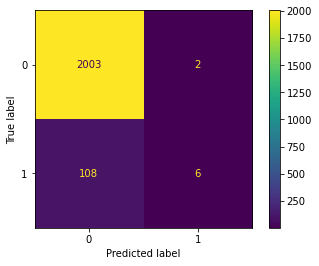

In [59]:
plot_confusion_matrix(gs, X_test, y_test)

In [60]:
# make sure the scoring table works
scoring_table

[{'Model': RandomForestClassifier(n_jobs=4, random_state=42),
  'Type': 'reg',
  'ROC-AUC': 0.8560812880080502,
  'Precision': 0.75,
  'Recall': 0.05263157894736842,
  'F1': 0.09836065573770492,
  'clsf__ccp_alpha': 0,
  'clsf__max_depth': 10,
  'clsf__n_estimators': 300}]

In [77]:
#submit to kaggle
submit_kaggle('submit_rf', gs)

###  RandomForest Kaggle

<img  src="../images/submit_rf2.png">

<a id = '2.2'><a/>
### 2.2 Gradient Boost regular
* [Back To Top](#Content) 

In [61]:
# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)

params_gb = {
    'clsf__learning_rate': [ 0.01, 0.1],
    'clsf__max_depth': [7, 10],
    'clsf__ccp_alpha':[0, 0.1],
    'clsf__n_estimators':[200, 350]
}

In [62]:
gs_gb=run_model(gb, params_gb)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.01
clsf__max_depth : 7
clsf__n_estimators : 350
[[1995   10]
 [ 103   11]]


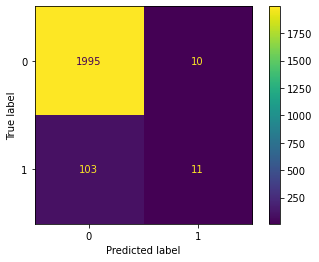

In [64]:
plot_confusion_matrix(gs_gb, X_test, y_test)

In [65]:
pd.DataFrame(scoring_table).sort_values(by='ROC-AUC', ascending=False)

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.856081,0.75000,0.052632,0.098361,0,10,300,NaN
1,GradientBoostingClassifier(random_state=42),reg,0.835177,0.52381,0.096491,0.162963,0,7,350,0.01


In [259]:
# recall is quite low. smote will be needed.

In [ ]:
submit_kaggle('submit_gb', gs_gb)

###  GradientBoost Kaggle

<img  src="../images/submit_gb.png">

<a id = '2.3'><a/>
### 2.3 PCA model setup
* [Back To Top](#Content) 

- with first first we will see if any interaction terms look interesting in term of predictive power
- secondly, we will run 'explained variance' method to see how many PCA compenents are needed to explain 98%+ of the total variance

In [149]:
# Poly by power of 2.  
pf = PolynomialFeatures(degree=2, include_bias=True, interaction_only=True )  
# Fit and transform our X data using Polynomial Features.  
X_poly = pf.fit_transform(X)

#transform the real (Kaggle) test set
test_poly = pf.transform(test)
                         
#Train/test split our data.
Xp_train, Xp_test, y_train, y_test = train_test_split(X_poly,
                                                            y,
                                                            stratify=y,
                                                            random_state=42)      

# Instantiate our StandardScaler.
sc = StandardScaler()
# Scale X_train.
Xp_trainsc = sc.fit_transform(Xp_train)
# Scale X_test.
Xp_testsc = sc.transform(Xp_test)
# Scale the real Kaggle test set
testsc = sc.transform(test_poly)

In [179]:
pf.get_feature_names(X.columns)

['1',
 'latitude',
 'longitude',
 'dum_species',
 'tavg',
 'preciptotal',
 'stnpressure',
 'sealevel',
 'resultspeed',
 'resultdir',
 'avgspeed',
 'humidity',
 'daylength',
 'tavg_lag14',
 'humidity_lag14',
 'resultspeed_lag14',
 'preciptotal_lag14',
 'dumweek_28',
 'dumweek_29',
 'dumweek_30',
 'dumweek_31',
 'dumweek_32',
 'dumweek_33',
 'dumweek_34',
 'dumweek_35',
 'dumweek_36',
 'dumweek_37',
 'dumweek_38',
 'dumweek_39',
 'latitude longitude',
 'latitude dum_species',
 'latitude tavg',
 'latitude preciptotal',
 'latitude stnpressure',
 'latitude sealevel',
 'latitude resultspeed',
 'latitude resultdir',
 'latitude avgspeed',
 'latitude humidity',
 'latitude daylength',
 'latitude tavg_lag14',
 'latitude humidity_lag14',
 'latitude resultspeed_lag14',
 'latitude preciptotal_lag14',
 'latitude dumweek_28',
 'latitude dumweek_29',
 'latitude dumweek_30',
 'latitude dumweek_31',
 'latitude dumweek_32',
 'latitude dumweek_33',
 'latitude dumweek_34',
 'latitude dumweek_35',
 'latitude

In [182]:
# creat a new df with polynomial columns, interaction only
new = pd.DataFrame(Xp_trainsc, columns = pf.get_feature_names(X.columns))

In [183]:
new.head()

,1,latitude,longitude,dum_species,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,...,dumweek_35 dumweek_36,dumweek_35 dumweek_37,dumweek_35 dumweek_38,dumweek_35 dumweek_39,dumweek_36 dumweek_37,dumweek_36 dumweek_38,dumweek_36 dumweek_39,dumweek_37 dumweek_38,dumweek_37 dumweek_39,dumweek_38 dumweek_39
0,0.0,-1.602313,1.133388,-0.489074,-1.122594,-0.464266,-1.514397,-1.681249,1.036524,1.236051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.946417,-0.430646,1.493423,0.790436,1.525244,-0.046916,-0.090089,1.018858,0.507860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.120524,0.040384,-0.489074,0.658503,-0.464266,0.255212,0.286764,-1.242348,0.563875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.879923,1.068817,-0.489074,1.054303,-0.464266,0.298373,0.244892,-1.136354,-0.780478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.263587,-0.662482,-0.489074,1.054303,-0.464266,0.298373,0.244892,-1.136354,-0.780478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
# top polynomial columns with negative correlation to west nile
new.corrwith(y_train).dropna().sort_values()[:10]

resultspeed humidity         -0.048481
resultspeed humidity_lag14   -0.045561
resultspeed                  -0.041324
latitude resultspeed         -0.041271
sealevel resultspeed         -0.041232
stnpressure resultspeed      -0.041224
humidity resultspeed_lag14   -0.040749
dum_species resultspeed      -0.039273
resultspeed daylength        -0.039261
avgspeed humidity            -0.038062
dtype: float64

In [189]:
# top polynomial columns with positive correlation to west nile
new.corrwith(y_train).dropna().sort_values(ascending=False)[:10]

tavg_lag14 dumweek_35     0.042380
tavg dumweek_35           0.042053
longitude resultspeed     0.041301
resultdir dumweek_35      0.039605
latitude dumweek_35       0.034497
dumweek_35                0.034483
stnpressure dumweek_35    0.034364
sealevel dumweek_35       0.034355
daylength dumweek_35      0.033983
latitude stnpressure      0.033611
dtype: float64

- set up pca to find out how many pca components are needed to reach 98%+ explained variance ratio. use that n_components to input into our run_models

In [152]:
# Instantiate PCA.
pca = PCA(random_state=42)

# Fit and transform PCA for train, transform for test
Z_train = pca.fit_transform(Xp_trainsc)

Z_test = pca.transform(Xp_testsc)
Z_kaggle_test = pca.transform(testsc)


In [154]:
expl_var = np.cumsum(pca.explained_variance_ratio_)[:90]

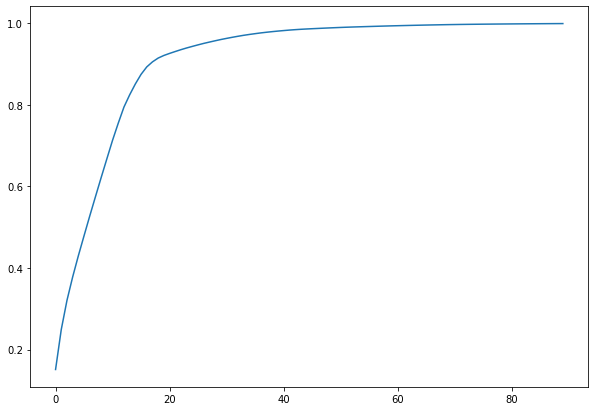

In [155]:
plt.figure(figsize=(10,7))
plt.plot(range(len(expl_var)), expl_var)
plt.show()

In [158]:
# 50 components give us around 99% of explained variance
expl_var[50]

0.9893366557127165

<a id = '2.4'><a/>
### 2.4 Gradient Boost w/poly features+PCA
* [Back To Top](#Content)

In [160]:
params_gb

{'clsf__learning_rate': [0.01, 0.1],
 'clsf__max_depth': [7, 10],
 'clsf__ccp_alpha': [0, 0.1],
 'clsf__n_estimators': [200, 350]}

In [161]:
gs_gb_pca=run_model(gb, params_gb, 'pca')

Fitting 4 folds for each of 16 candidates, totalling 64 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.01
clsf__max_depth : 7
clsf__n_estimators : 350
[[1981   24]
 [  99   15]]


In [162]:
submit_gb_pca = pd.DataFrame()
submit_gb_pca['Id'] = test.index
submit_gb_pca.set_index('Id', drop=True,inplace=True)
submit_gb_pca['WnvPresent'] =gs_gb_pca.predict_proba(test_poly)[:,1]
submit_gb_pca.to_csv('../datasets/submit_gb_pca2.csv')

###  Gradient Boost w/smote Kaggle

<img src="../images/submit_gbpca.png" alt="not great">

<a id = '2.5'><a/>
### 2.5 Log Reg w/poly features+smote+PCA
* [Back To Top](#Content)

- run_models function does not handle PCA and SMOTE at the same time so we'll do it below, 'manually'

In [225]:
lr = LogisticRegression(
    solver='liblinear',
    random_state=42,
)

params_lr = {
    'clsf__penalty': ['l1'],
    'clsf__C': [0.1, 1.5],
    'clsf__max_iter': [200]
}

pipe_lrpca = Pipeline_imb([
            ('pf', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True )),
            ('sc', StandardScaler()),
            ('pca', PCA(n_components=50, random_state=42)),
            ('smpl', SMOTE(sampling_strategy='auto', random_state=42)),
            ('clsf', lr)
        ])



In [226]:
  grid_lrpca = GridSearchCV(
        pipe_lrpca,
        param_grid=params_lr,
        scoring='roc_auc',
        cv=4,
        n_jobs=-1,
        verbose=2)

In [227]:
grid_lrpca.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pf',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('sc', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=50, random_state=42)),
                                       ('smpl', SMOTE(random_state=42)),
                                       ('clsf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clsf__C': [0.1, 1.5], 'clsf__max_iter': [200],
                         'clsf__penalty': ['l1']},
             scoring='roc_auc', verbose=2)

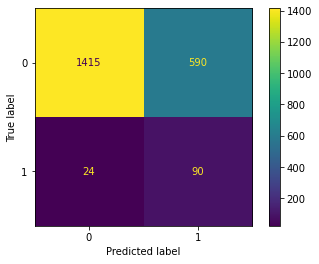

In [228]:
plot_confusion_matrix(grid_lrpca, X_test, y_test)

In [229]:
# attach the results to our table list here, since we didn't use the run_models function
pred = grid_lrpca.predict(X_test)
pred_prob = grid_lrpca.predict_proba(X_test)[:, 1]

table = {'Model': lr}
table['Type'] = 'pcasmote'
table['ROC-AUC'] = roc_auc_score(y_test, pred_prob)
table['Precision'] = precision_score(y_test, pred)
table['Recall'] = recall_score(y_test, pred)
table['F1'] = f1_score(y_test, pred)

for key, value in grid_lrpca.best_params_.items():
        table[key] = value

scoring_table.append(table)

In [211]:
submit_kaggle('submit_lrpca', grid_lrpca)

###  LogReg w/smote and PCA Kaggle

<img src="../images/submit_lrpcasmote.png" alt="not great">

<a id = '2.6'><a/>
### 2.6 Random Forest w/smotetomek+PCA
* [Back To Top](#Content)

In [216]:
rf = RandomForestClassifier(
    random_state=42,
)

params_rfpca = {
    'clsf__n_estimators': [ 200,300],
    'clsf__max_depth': [ 7,10],
    'clsf__min_samples_leaf':[4,10]
}


pipe_rfpca = Pipeline_imb([
            ('pf', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True )),
            ('sc', StandardScaler()),
            ('pca', PCA(n_components=50, random_state=42)),
            ('smpl', SMOTETomek(random_state=42)),
            ('clsf', rf)
        ])

In [217]:
grid_rfpca = GridSearchCV(
        pipe_rfpca,
        param_grid=params_rfpca,
        scoring='roc_auc',
        cv=4,
        n_jobs=-1,
        verbose=2)

In [218]:
grid_rfpca.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pf',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('sc', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=50, random_state=42)),
                                       ('smpl', SMOTETomek(random_state=42)),
                                       ('clsf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clsf__max_depth': [7, 10],
                         'clsf__min_samples_leaf': [4, 10],
                         'clsf__n_estimators': [200, 300]},
             scoring='roc_auc', verbose=2)

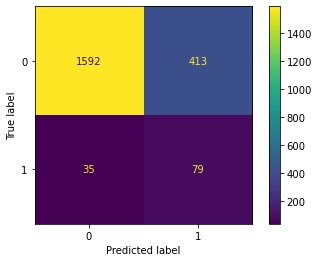

In [220]:
plot_confusion_matrix(grid_rfpca, X_test, y_test)

In [221]:
submit_kaggle('submit_rfpca', grid_rfpca)

###  Random Forest w/smote and pca50 Kaggle

<img src="../images/submit_rfsmotepca.png" alt="not great">

In [223]:
pred = grid_rfpca.predict(X_test)
pred_prob = grid_rfpca.predict_proba(X_test)[:, 1]

table = {'Model': rf}
table['Type'] = 'pcasmote'
table['ROC-AUC'] = roc_auc_score(y_test, pred_prob)
table['Precision'] = precision_score(y_test, pred)
table['Recall'] = recall_score(y_test, pred)
table['F1'] = f1_score(y_test, pred)

for key, value in grid_rfpca.best_params_.items():
        table[key] = value

scoring_table.append(table)

<a id = '2.7'><a/>
### 2.7 Log Reg w/smote
* [Back To Top](#Content)

In [78]:
lr = LogisticRegression(
    solver='liblinear',
    random_state=42,
)

params_lr_smote = {
    'clsf__penalty': ['l1', 'l2'],
    'clsf__C': [0.1, 1.5, 10, 40],
    'clsf__max_iter': [50, 200, 1000],
    'smpl__k_neighbors': [3, 5, 7],
}

In [79]:
gs_lr_smote = run_model(lr, params_lr_smote, 'smote')

Fitting 4 folds for each of 72 candidates, totalling 288 fits


 LogisticRegression(random_state=42, solver='liblinear') 

 Best Parameters:
------------------------------ 

clsf__C : 0.1
clsf__max_iter : 50
clsf__penalty : l2
smpl__k_neighbors : 5
[[1323  682]
 [  18   96]]


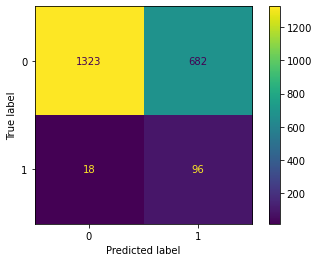

In [80]:
plot_confusion_matrix(gs_lr_smote, X_test, y_test)

In [81]:
pd.DataFrame(scoring_table)

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate,clsf__C,clsf__max_iter,clsf__penalty,smpl__k_neighbors
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.856081,0.750000,0.052632,0.098361,0.0,10.0,300.0,NaN,NaN,NaN,NaN,NaN
1,GradientBoostingClassifier(random_state=42),reg,0.835177,0.523810,0.096491,0.162963,0.0,7.0,350.0,0.01,NaN,NaN,NaN,NaN
2,"LogisticRegression(random_state=42, solver='li...",smote,0.811014,0.123393,0.842105,0.215247,NaN,NaN,NaN,NaN,0.1,50.0,l2,5.0


In [462]:
pd.DataFrame(scoring_table)

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate,clsf__C,clsf__max_iter,clsf__penalty,smpl__k_neighbors,smpl__sampling_strategy
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.862611,0.000000,0.000000,0.000000,0.0,7.0,300.0,NaN,NaN,NaN,NaN,NaN,NaN
1,GradientBoostingClassifier(random_state=42),reg,0.830564,0.291139,0.201754,0.238342,0.0,7.0,200.0,0.10,NaN,NaN,NaN,NaN,NaN
2,GradientBoostingClassifier(random_state=42),pca,0.835033,0.480000,0.105263,0.172662,0.0,7.0,350.0,0.01,NaN,NaN,NaN,NaN,NaN
3,"LogisticRegression(random_state=42, solver='li...",pca,0.783445,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,10.0,50.0,l2,NaN,NaN
4,"LogisticRegression(random_state=42, solver='sa...",pca,0.783388,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,40.0,1000.0,l2,NaN,NaN
5,"LogisticRegression(random_state=42, solver='li...",smote,0.782898,0.113842,0.771930,0.198422,NaN,NaN,NaN,NaN,0.1,50.0,l1,5.0,minority
6,GradientBoostingClassifier(random_state=42),smote,0.843306,0.223350,0.385965,0.282958,0.0,7.0,150.0,0.10,NaN,NaN,NaN,NaN,NaN


In [82]:
submit_kaggle('submit_lr_smote', gs_lr_smote)

###  LogReg w/smote Kaggle

<img src="../images/submit_lrsmote2.png" alt="not great">

<a id = '2.8'><a/>
### 2.8 Gradient Boost w/smote
* [Back To Top](#Content)

In [94]:
gb = GradientBoostingClassifier(random_state=42)

params_gb_smote = {
    'clsf__learning_rate': [ 0.05, 0.1],
    'clsf__max_depth': [7, 10],
    'clsf__ccp_alpha':[0, 0.01],
    'clsf__n_estimators':[150, 300],
    'smpl__k_neighbors': [3, 5, 7],
}

In [95]:
gs_gb_smote = run_model(gb, params_gb_smote, 'smote')

Fitting 4 folds for each of 16 candidates, totalling 64 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.05
clsf__max_depth : 7
clsf__n_estimators : 150
[[1763  242]
 [  57   57]]


In [87]:
submit_kaggle('submit_gb_smote', gs_gb_smotetomek)

### Gradient Boost w/smote Kaggle

<img src="../images/submit_gbsmote.png" alt="not great">

In [99]:
gb = GradientBoostingClassifier(random_state=42)

params_gb_smotetomek = {
    'clsf__learning_rate': [0.025, 0.05],
    'clsf__max_depth': [7, 10],
    'clsf__ccp_alpha':[0, 0.01],
    'clsf__n_estimators':[150, 250],
    'smpl__sampling_strategy':['all', 'auto']
}

<a id = '2.9'><a/>
### 2.9 Gradient Boost w/smotetomek
* [Back To Top](#Content)

In [100]:
gs_gb_smotetomek = run_model(gb, params_gb_smotetomek, 'smotetomek')

Fitting 4 folds for each of 32 candidates, totalling 128 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.05
clsf__max_depth : 7
clsf__n_estimators : 150
smpl__sampling_strategy : all
[[1756  249]
 [  53   61]]


In [98]:
submit_kaggle('submit_gbsmotetomek', gs_gb_smotetomek)

### Gradient boost w/smotetomek Kaggle

<img src="../images/submit_gbsmotetomek.png" alt="not great">

<a id = '2.10'><a/>
### 2.10 Random Forest w/smote
* [Back To Top](#Content)

In [101]:
rf = RandomForestClassifier(random_state=42, n_jobs=4)

params_rf_smote = {
    'clsf__n_estimators': [150, 250],
    'clsf__max_depth': [ 5, 7],
    'clsf__ccp_alpha':[0, 0.01],
    'smpl__k_neighbors': [3, 5, 7],
}

In [102]:
gs_rf_smote = run_model(rf, params_rf_smote, 'smote')

Fitting 4 folds for each of 24 candidates, totalling 96 fits


 RandomForestClassifier(n_jobs=4, random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__max_depth : 7
clsf__n_estimators : 250
smpl__k_neighbors : 5
[[1429  576]
 [  24   90]]


In [103]:
submit_kaggle('rf_smote', gs_rf_smote)

### Random Forest w/smote Kaggle

<img src="../images/submit_rfsmote2.png" alt="not great">

<a id = '2.11'><a/>
### 2.11 XGBoost w/smotetomek
* [Back To Top](#Content)

In [116]:
xg_smotetomek = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    objective='binary:logistic',
    random_state=42,
)

xg_smotetomek_params = { 
    'clsf__max_depth': [3, 5],
    'clsf__gamma' : [0.15, 0.25],
    'clsf__learning_rate' : [0.125, 0.2],
    'clsf__n_estimators':[150, 200],
    'clsf__reg_alpha':[5,10],
    'smpl__sampling_strategy':['all', 'auto', 'not minority']
}

In [117]:
gs_xg_smotetomek = run_model(xg_smotetomek, xg_smotetomek_params, kind='smotetomek')

Fitting 4 folds for each of 8 candidates, totalling 32 fits


 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) 

 Best Parameters:
------------------------------ 

clsf__gamma : 0.15
clsf__learning_rate : 0.125
clsf__max_depth : 5
clsf__n_estimators : 150
clsf__reg_alpha : 10
smpl__sampling_strategy : all

In [118]:
submit_kaggle('submit_xgsmotetomek', gs_xg_smotetomek)

### XGBoost w/smote Kaggle

<img src="../images/submit_xgsmotetomek.png" alt="not great">

<a id = '3.0'><a/>
### 3.0 Make model table
* [Back To Top](#Content)

In [237]:
Table = pd.DataFrame(scoring_table)

#add Kaggle scores
Table['Kaggle_AUC'] = [0.712, 0.718, 0.648, 0.676, 0.698, 0.686, 0.697, 0.700, 0.716, 0.707]

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate,clsf__C,clsf__max_iter,clsf__penalty,smpl__k_neighbors,smpl__sampling_strategy,clsf__gamma,clsf__reg_alpha,clsf__min_samples_leaf,Kaggle_AUC
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.856081,0.750000,0.052632,0.098361,0.0,10.0,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712
1,GradientBoostingClassifier(random_state=42),reg,0.835177,0.523810,0.096491,0.162963,0.0,7.0,350.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.718
2,"LogisticRegression(random_state=42, solver='li...",smote,0.811014,0.123393,0.842105,0.215247,NaN,NaN,NaN,NaN,0.1,50.0,l2,5.0,NaN,NaN,NaN,NaN,0.685
3,GradientBoostingClassifier(random_state=42),smote,0.835501,0.190635,0.500000,0.276029,0.0,7.0,150.0,0.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.697
4,GradientBoostingClassifier(random_state=42),smotetomek,0.837258,0.196774,0.535088,0.287736,0.0,7.0,150.0,0.050,NaN,NaN,NaN,NaN,all,NaN,NaN,NaN,0.700
5,"RandomForestClassifier(n_jobs=4, random_state=42)",smote,0.829269,0.135135,0.789474,0.230769,0.0,7.0,250.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0.716
6,"XGBClassifier(base_score=None, booster=None, c...",smotetomek,0.840869,0.205212,0.552632,0.299287,NaN,5.0,150.0,0.125,NaN,NaN,NaN,NaN,all,0.15,10.0,NaN,0.707
7,GradientBoostingClassifier(random_state=42),pca,0.831113,0.384615,0.131579,0.196078,0.0,7.0,350.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.648
8,RandomForestClassifier(random_state=42),pcasmote,0.828420,0.160569,0.692982,0.260726,NaN,7.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.698
9,"LogisticRegression(random_state=42, solver='li...",pcasmote,0.808610,0.132353,0.789474,0.226700,NaN,NaN,NaN,NaN,0.1,200.0,l1,NaN,NaN,NaN,NaN,NaN,0.676


In [ ]:
Table

<a id = '4.0'><a/>
### 4.0 Model Conclusions
* [Back To Top](#Content)

**Model conclusions:**

- the real difficulty is models encountered is identifying west-nile carrying mosquitos correctly, since only about 5% of them carry the virus
- our goal is to avoid false negatives ( identifying west-nile mosquitos as normal). we do not mind a high number of false positives (identifying normal mosquitos as west-nile carrying ones)
- there is a clear tradeoff between recall and precision. models employing smote score high on recall metrics, as smote trains them to uncover more positives, but that comes at the expense of precision
- as such we care about high recall score, and do not mind seeing our precision score dip
- in addition to recall we also care about the overall soundness of the model. out of all the scores we trust the Kaggle competition score the most - ROC-AUC on completely unseen data
- **we thus choose Random Forest Classifier with SMOTE as our production model**
- it scores among top two in Kaggle ROC-AUC and recall, at 0.716 and 0.789 respectively.

In [233]:
Table['Kaggle_AUC'] = [0.712, 0.718, 0.648, 0.676, 0.698, 0.686, 0.697, 0.700, 0.716, 0.707]

In [238]:
# Table.to_csv('../datasets/modeltable2.csv', index=False)

In [235]:
# Table['Kaggle_AUC'] = [0.712, 0.718, 0.685, 0.697, 0.700, 0.716, 0.707, 0.648, 0.698, 0.676]

<a id = '5.0'><a/>
### 5.0 Features Importances
* [Back To Top](#Content)

In [248]:
feat_imp = gs_rf_smote.best_estimator_.named_steps['clsf'].feature_importances_

In [251]:
top_features = pd.DataFrame({'top_features': X.columns , 'coef': feat_imp}).sort_values(
    ['coef'], ascending=False)
top_features

,top_features,coef
11,daylength,0.239962
2,dum_species,0.143651
3,tavg,0.082475
12,tavg_lag14,0.081884
7,resultspeed,0.044318
9,avgspeed,0.042883
13,humidity_lag14,0.041539
10,humidity,0.041087
14,resultspeed_lag14,0.036409
1,longitude,0.032740


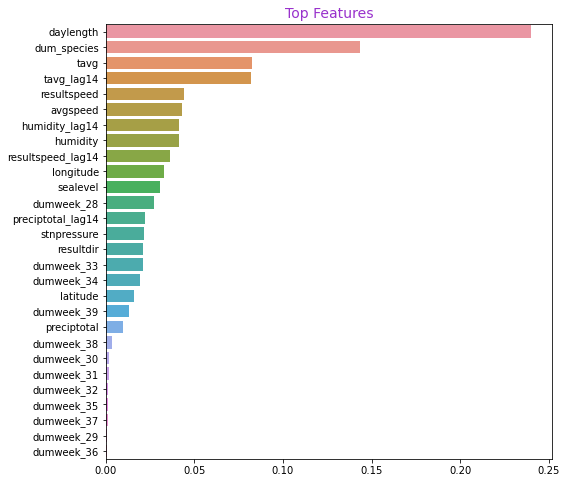

In [258]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=top_features['coef'] , y = top_features['top_features'])
plt.title('Top Features', fontsize=14, 
            color='Darkorchid')
plt.xlabel(None)
plt.ylabel(None)
plt.show()

- length of the day and mosquito species turned out to have had the most influence in predicting the incidence of WnV. 
- the days are longest on June 21st, the Summer Solistice, and after that they get shorter, just as our West Nile season gets under way. this implies that any effort to kill mosquitos should be undertaken in July and early August, just before the peak west nile season in late summer
- as far species are concerned, this knowledge is useful in predicting and modeling the spread of west nile. Spraying however, works on all mosquitoes species indiscriminately.
- some dummy week variable have proven more useful than others. Namely, week28 - the first week in our dummy mosquito season, and weeks 33 and 34 (the peaks of the season) have most predictive power. this is consistent with our eda finding in notebook 1
- we could have added some polynomial features, but we chose not to in order to maintain interpretability of our model and all of its features

<a id = '6.0'><a/>
### 6.0 Cost-Benifit analysis
* [Back To Top](#Content)

**COSTS**

- city of Chicago uses Zenivex spray to control its mosquito population. The cost, under some assumptions, come out to around $200USD per km² per week. 



**BENEFITS**

- the benefits are somewhat harder to quantify, and are based on many assumptions (see image below), but we came up with the figure of $160,000USD in productivity and medical costs that would be saved if every single west-nile carrying mosquito were eliminated.

**RESULT**

- 160000/200 gives us acceptable range of spraying of 800km². If we further assume that the summer spray season is about 8 weeks long, that gives us the upper limit for cost-effective spraying of 100km² per week. Anything more than 100km² per week and the City would be spending more money trying to eredicate the disease, then the disease, even in its most severe 2002 form, brings about in lost productivity and health-care costs.
- 100km² is only 15% of the area of the city of Chicago proper.
- calculations below:

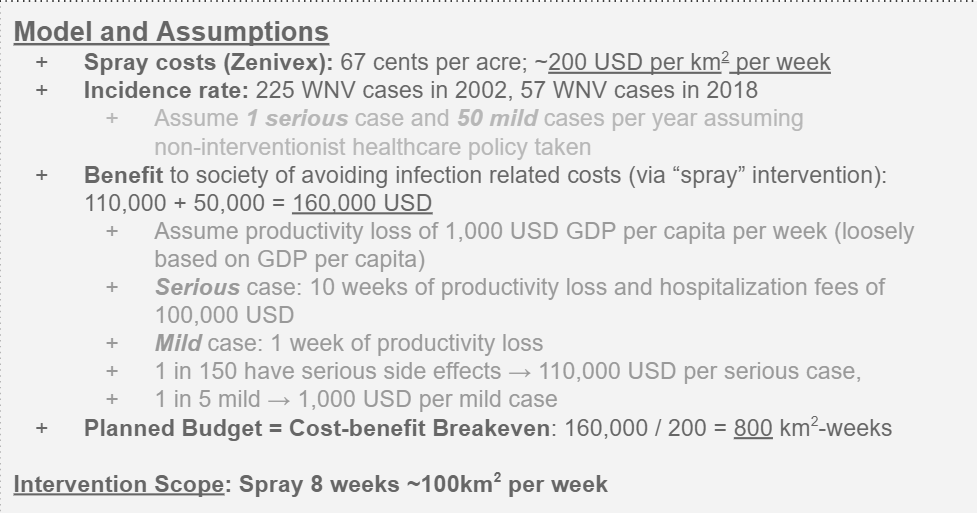

<a id = '7.0'><a/>
### 7.0 Conclusions
* [Back To Top](#Content)

**There are many reasons to suggest not spending resources on spraying:**

- our charts made during EDA section show no significant decrease in either the mosquito number nor in the incidence of WnV after previous spraying
- under reasonable assumption, we can only afford to spay 15% of the city area for 8 weeks during the peak mosquito season, which is wouldn't make much difference, as mosquitoes from other parts of the city could migrate to replace them

**Still, we believe, and this is our final recommendation, that limited spraying should take place.**

- even assuming that only 15% of the chicago area can be sprayed in any given week, we could use our model to maximize the efficiency of such a limited spray, by focusing on the areas in our model that give rise to highest 'WnV present' odds. (model.predic_proba) 
- scientifically speaking, the spray **does** kill of mosquitoes and their larvae. So even if our data doesn't show it, we choose to believe the science and use spraying as a mosquito-reduction technique. We will however use our findings of spray's lack of success, by deciding not spend do spend much funds on it.
- it is important for a city government to show that it cares about its people, so standing idly by while the virus is affecting its people is, politically speaking, not an option
- lastly, even though spraying does not have substantial effect now, it does not mean that it will remain so in the future, especially if west nile virus started spreading at faster rates. that is why it is important to have a well-oiled, functioning spraying program in place now, which can then easily be ramped up in the future if a need should arise.

In [ ]:
###  LogReg w/smote Kaggle

<img src="../images/submit_lrsmote2.png" alt="not great">